# BERT development for sentiment analysis



## Setup

The code snippet imports essential libraries and models for natural language processing using BERT with PyTorch. It includes the transformers library for pre-trained models, BERTModel, BertTokenizer, AdamW, and linear scheduling utilities. Additionally, it imports other necessary libraries for data manipulation, visualization, and machine learning tasks.

In [1]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
torch.cuda.empty_cache()

## Data Loading and Setup

This is executed in a Google Colab environment, mounts the Google Drive to the notebook. It establishes a connection to the specified file path containing a CSV file. The pandas library is then used to read the CSV file into a DataFrame (df). The command 'torch.cuda.empty_cache()' is employed, possibly to clear the GPU memory, ensuring efficient memory utilization during subsequent computations involving PyTorch.








In [2]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/UWE Data Science/Individual project/dataset/reviews_ori.csv'
df = pd.read_csv(file_path)
torch.cuda.empty_cache()

Mounted at /content/drive


## Dataset selection
Selects the first 15,000 rows from a DataFrame (df), prints the resulting shape,

In [3]:
df = df.head(15000)
print(df.shape)
torch.cuda.empty_cache()

(15000, 10)


Check for missing values:

In [4]:
df.info()
torch.cuda.empty_cache()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      15000 non-null  int64 
 1   ProductId               15000 non-null  object
 2   UserId                  15000 non-null  object
 3   ProfileName             15000 non-null  object
 4   HelpfulnessNumerator    15000 non-null  int64 
 5   HelpfulnessDenominator  15000 non-null  int64 
 6   Score                   15000 non-null  int64 
 7   Time                    15000 non-null  int64 
 8   Summary                 15000 non-null  object
 9   Text                    15000 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.1+ MB


Generates a count plot using Seaborn for the 'Score' column in the DataFrame 'df'

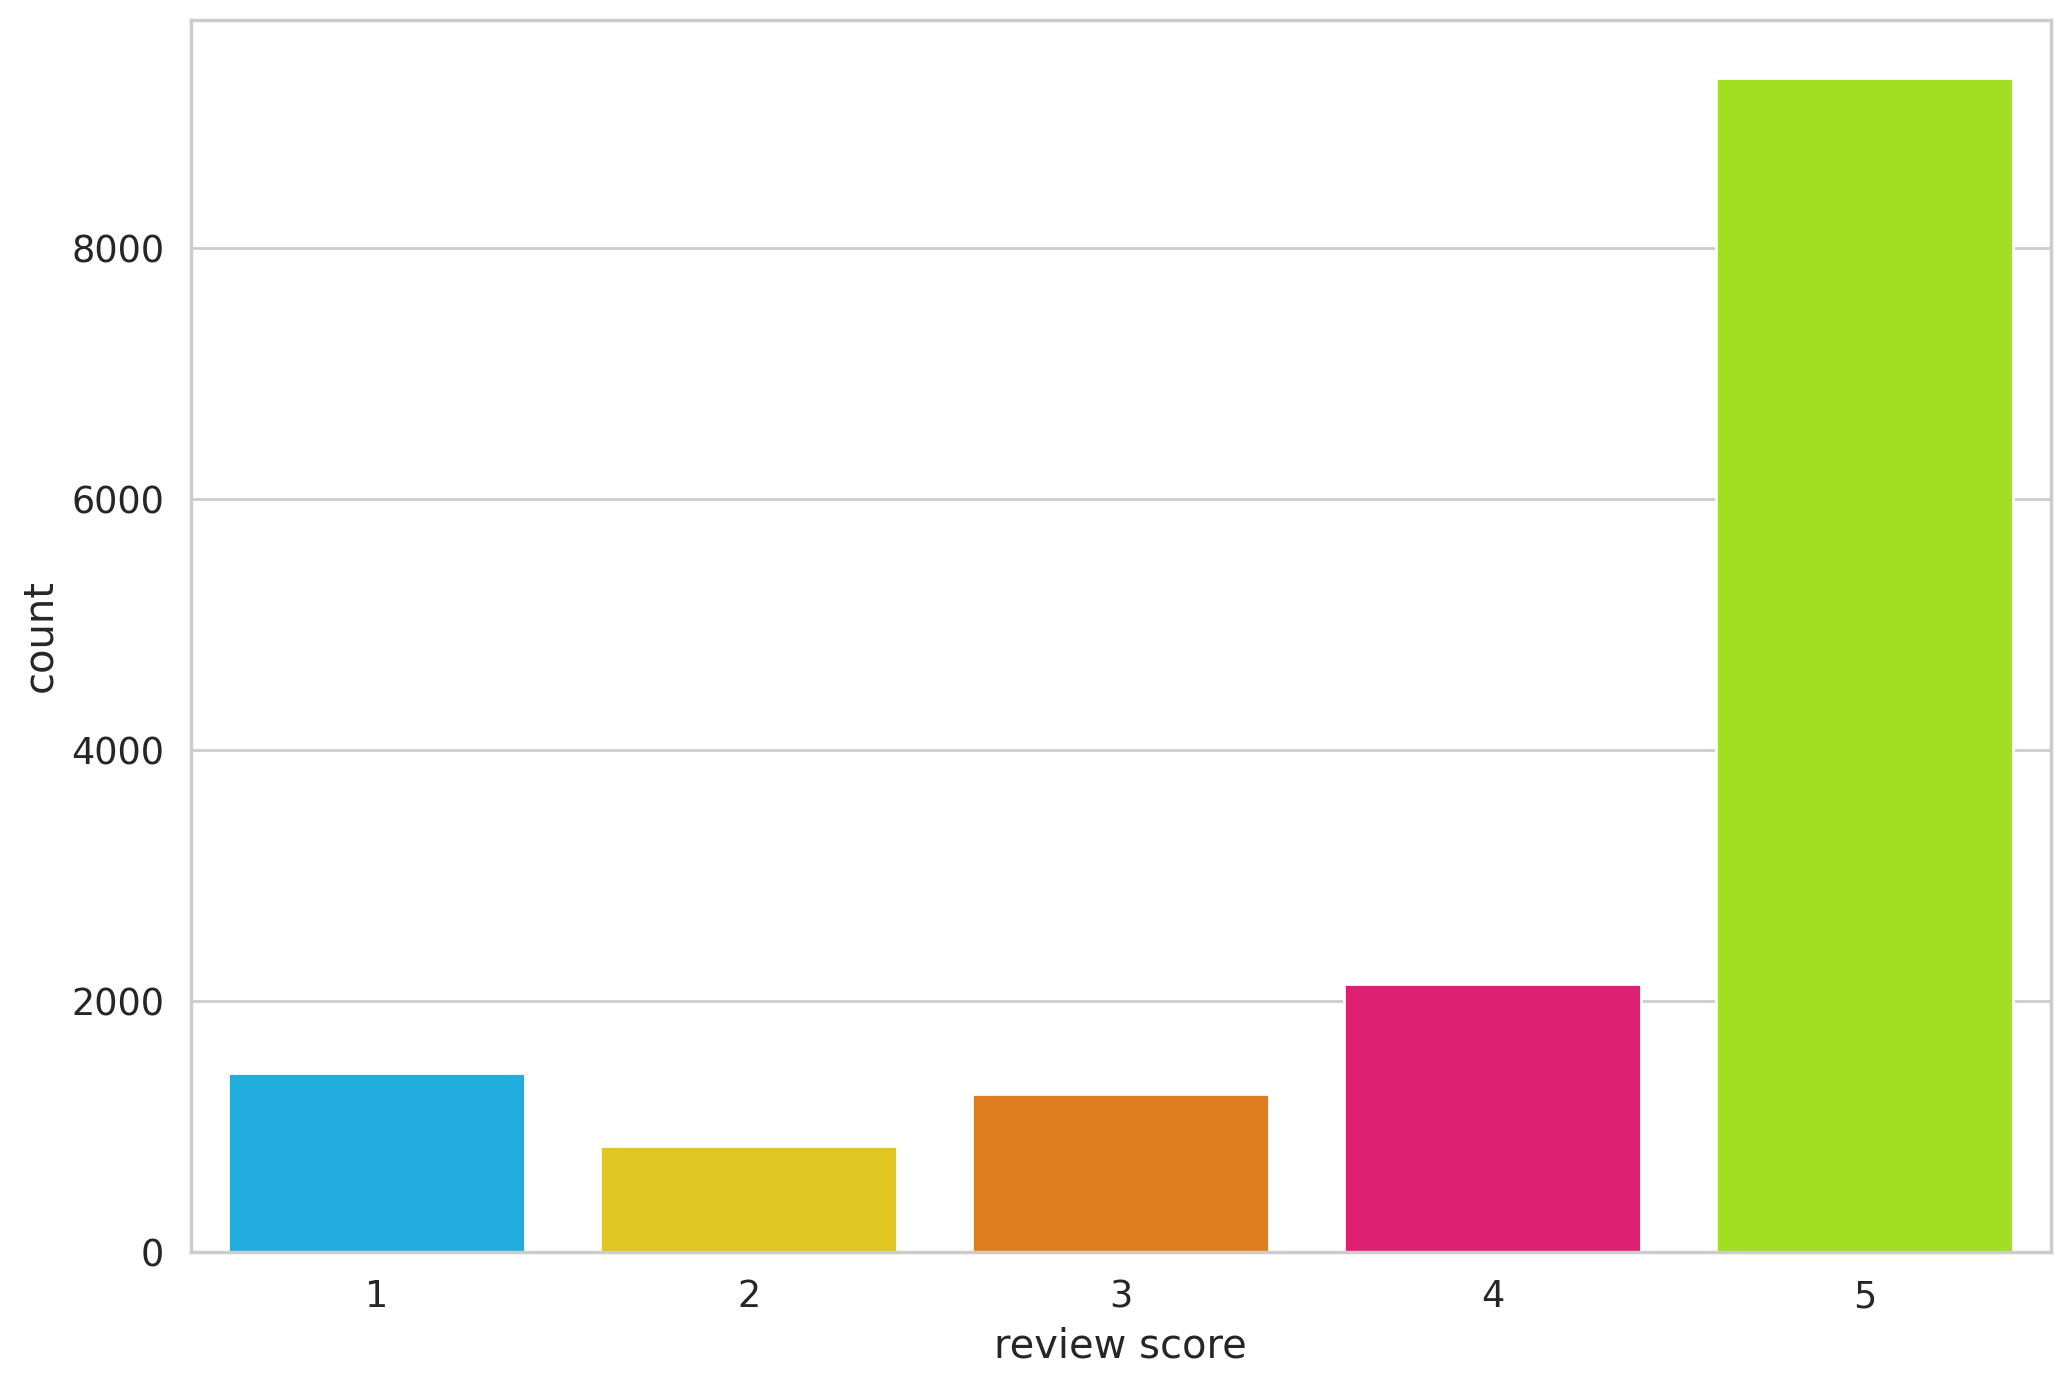

In [5]:
sns.countplot(df,x='Score')
plt.xlabel('review score')
torch.cuda.empty_cache()


To convert the dataset into negative, neutral, and positive sentiment categories based on the scores (1, 2, 3, 4, 5), you can create a new column in the DataFrame that represents sentiment categories.

In [6]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.Score.apply(to_sentiment)
torch.cuda.empty_cache()

Define the class as "Negative", "Positive" and Neutral

In [12]:
class_names = ['negative', 'neutral', 'positive']
torch.cuda.empty_cache()

Visualize the count plot

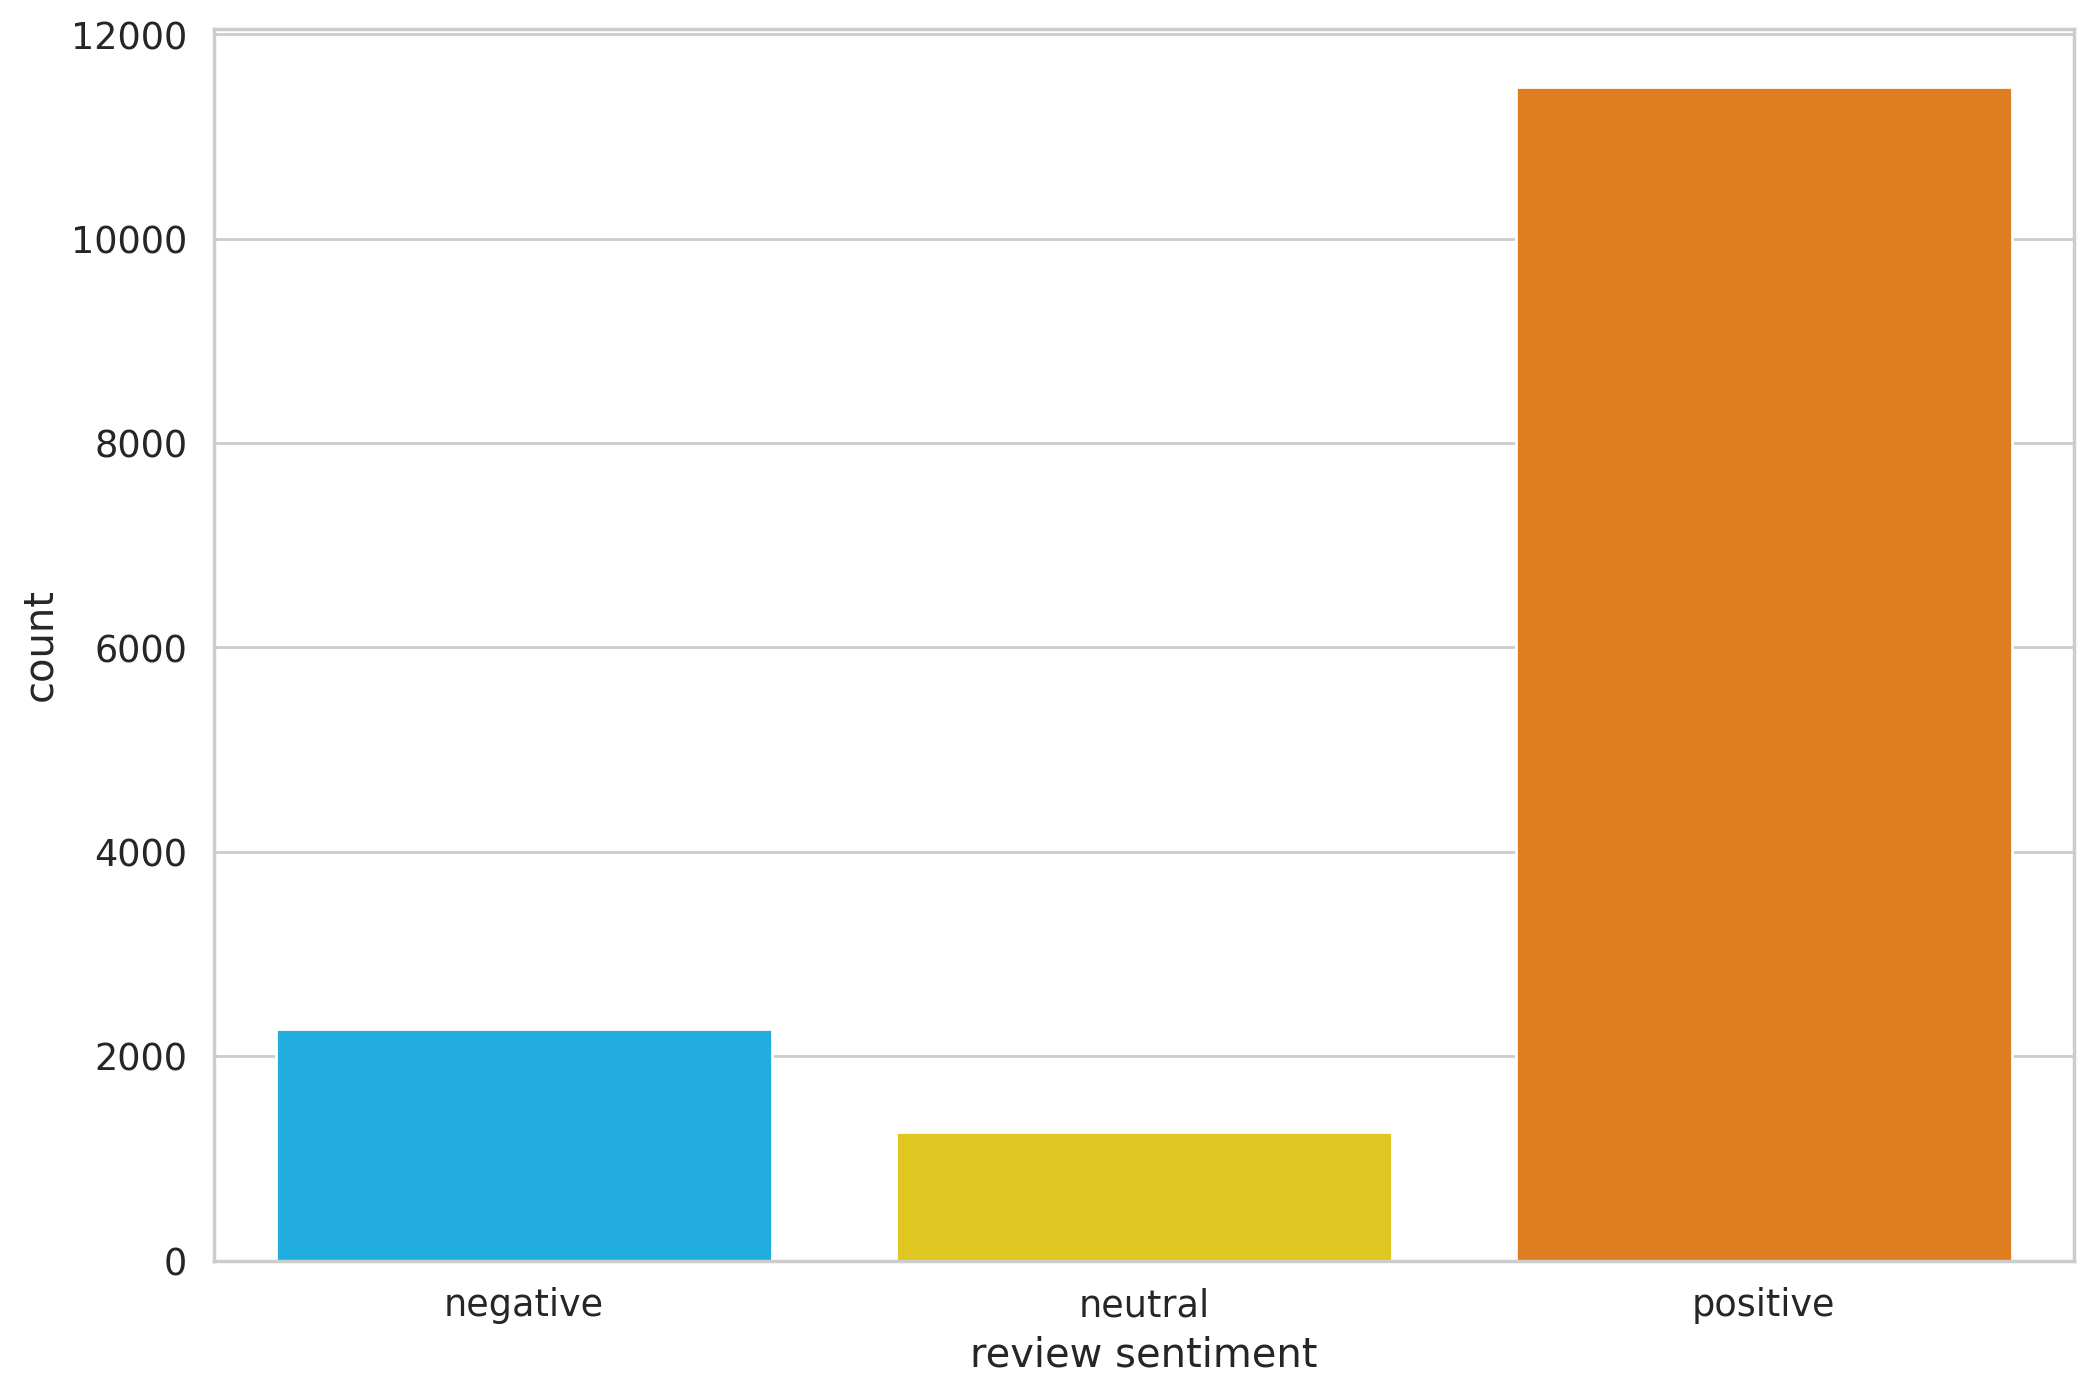

In [13]:
# Create a count plot
ax = sns.countplot(df, x="sentiment")
plt.xlabel('review sentiment')
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names)
plt.show()
torch.cuda.empty_cache()

Display the sentiment values

In [14]:
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

2    11482
0     2265
1     1253
Name: sentiment, dtype: int64


Resampling on a dataset to address class imbalance in the 'sentiment' column using the imbalanced-learn library.

In [15]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd


X = df.drop(columns=['sentiment'])
y = df['sentiment']
resampling_strategy = 'minority'

if resampling_strategy == 'minority':
    oversampler = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
else:
    undersampler = RandomUnderSampler(sampling_strategy='majority')
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='sentiment')], axis=1)
df = df_resampled
print(df['sentiment'].value_counts())


2    11482
1    11482
0     2265
Name: sentiment, dtype: int64


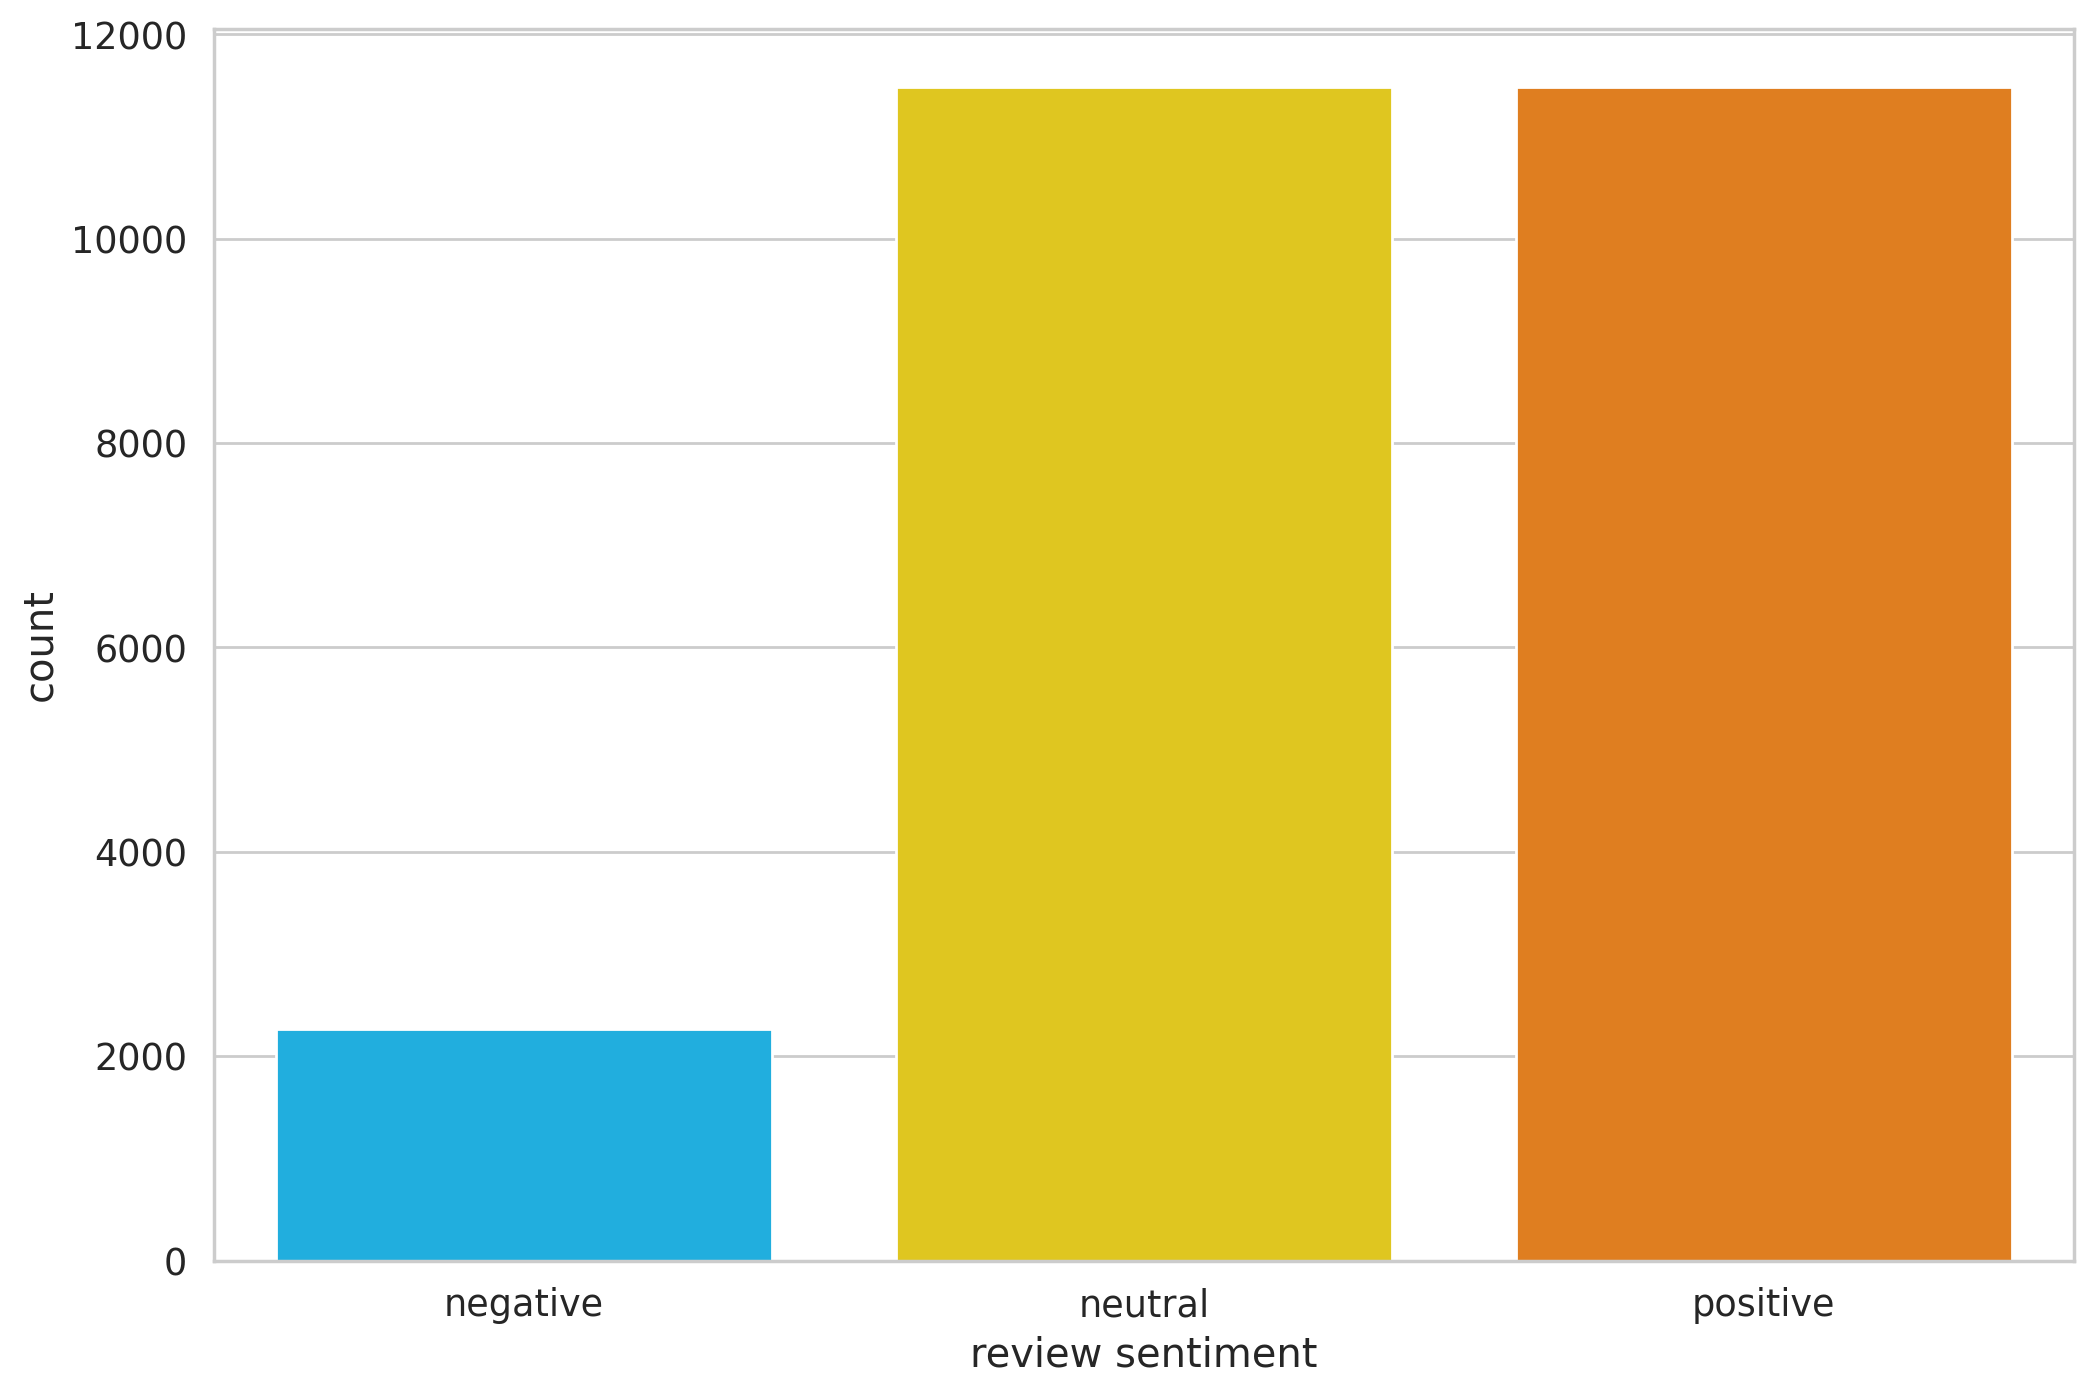

In [16]:
# Create a count plot
ax = sns.countplot(df_resampled, x="sentiment")
plt.xlabel('review sentiment')
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names)
plt.show()
torch.cuda.empty_cache()

## Data Preprocessing




## Extract Linguistic feature

In [7]:
!pip install pandas scikit-learn transformers

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

In [9]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Extract N-gram Features:

In [12]:
# Use CountVectorizer to extract n-gram features
ngram_range = (1, 2)
vectorizer = CountVectorizer(ngram_range=ngram_range)
X_train_ngram = vectorizer.fit_transform(train_df['Text'])
X_test_ngram = vectorizer.transform(test_df['Text'])

## Train with logistic regression model

In [13]:
# Train a logistic regression model on n-gram features
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_ngram, train_df['sentiment'])

# Make predictions on the test set
predictions_ngram = classifier.predict(X_test_ngram)

# Evaluate accuracy
accuracy_ngram = accuracy_score(test_df['sentiment'], predictions_ngram)
print(f'Accuracy with n-gram features: {accuracy_ngram:.2f}')


Accuracy with n-gram features: 0.85


## Tokenizing

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training and testing text
train_texts = train_df['Text'].tolist()
test_texts = test_df['Text'].tolist()

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

##Prepare Data for BERT

In [15]:
# Convert data to PyTorch tensors
train_labels = torch.tensor(train_df['sentiment'].tolist())
test_labels = torch.tensor(test_df['sentiment'].tolist())

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              train_labels)

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             test_labels)


## Train BERT Model with N-Gram Feature

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set up DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Training settings
epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

# Training loop
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
predictions_bert = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions_bert.extend(torch.argmax(logits, dim=1).tolist())

# Evaluate accuracy
accuracy_bert = accuracy_score(test_df['sentiment'], predictions_bert)
print(f'Accuracy with BERT features: {accuracy_bert:.2f}')



Sets a variable PRE_TRAINED_MODEL_NAME with the value 'bert-base-cased', indicating the choice of a pre-trained BERT model with a cased vocabulary.

In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
torch.cuda.empty_cache()

Load a pre-trained BertTokenizer

In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Sequence Length

BERT operates with fixed-length sequences, and we'll employ a straightforward approach to determine the maximum length. To achieve this, we'll calculate and store the token length of each review.

In [19]:
token_lens = []

for txt in df.Text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
  torch.cuda.empty_cache()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Create a plot the distribution:

<ipython-input-20-83d800f93b0d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


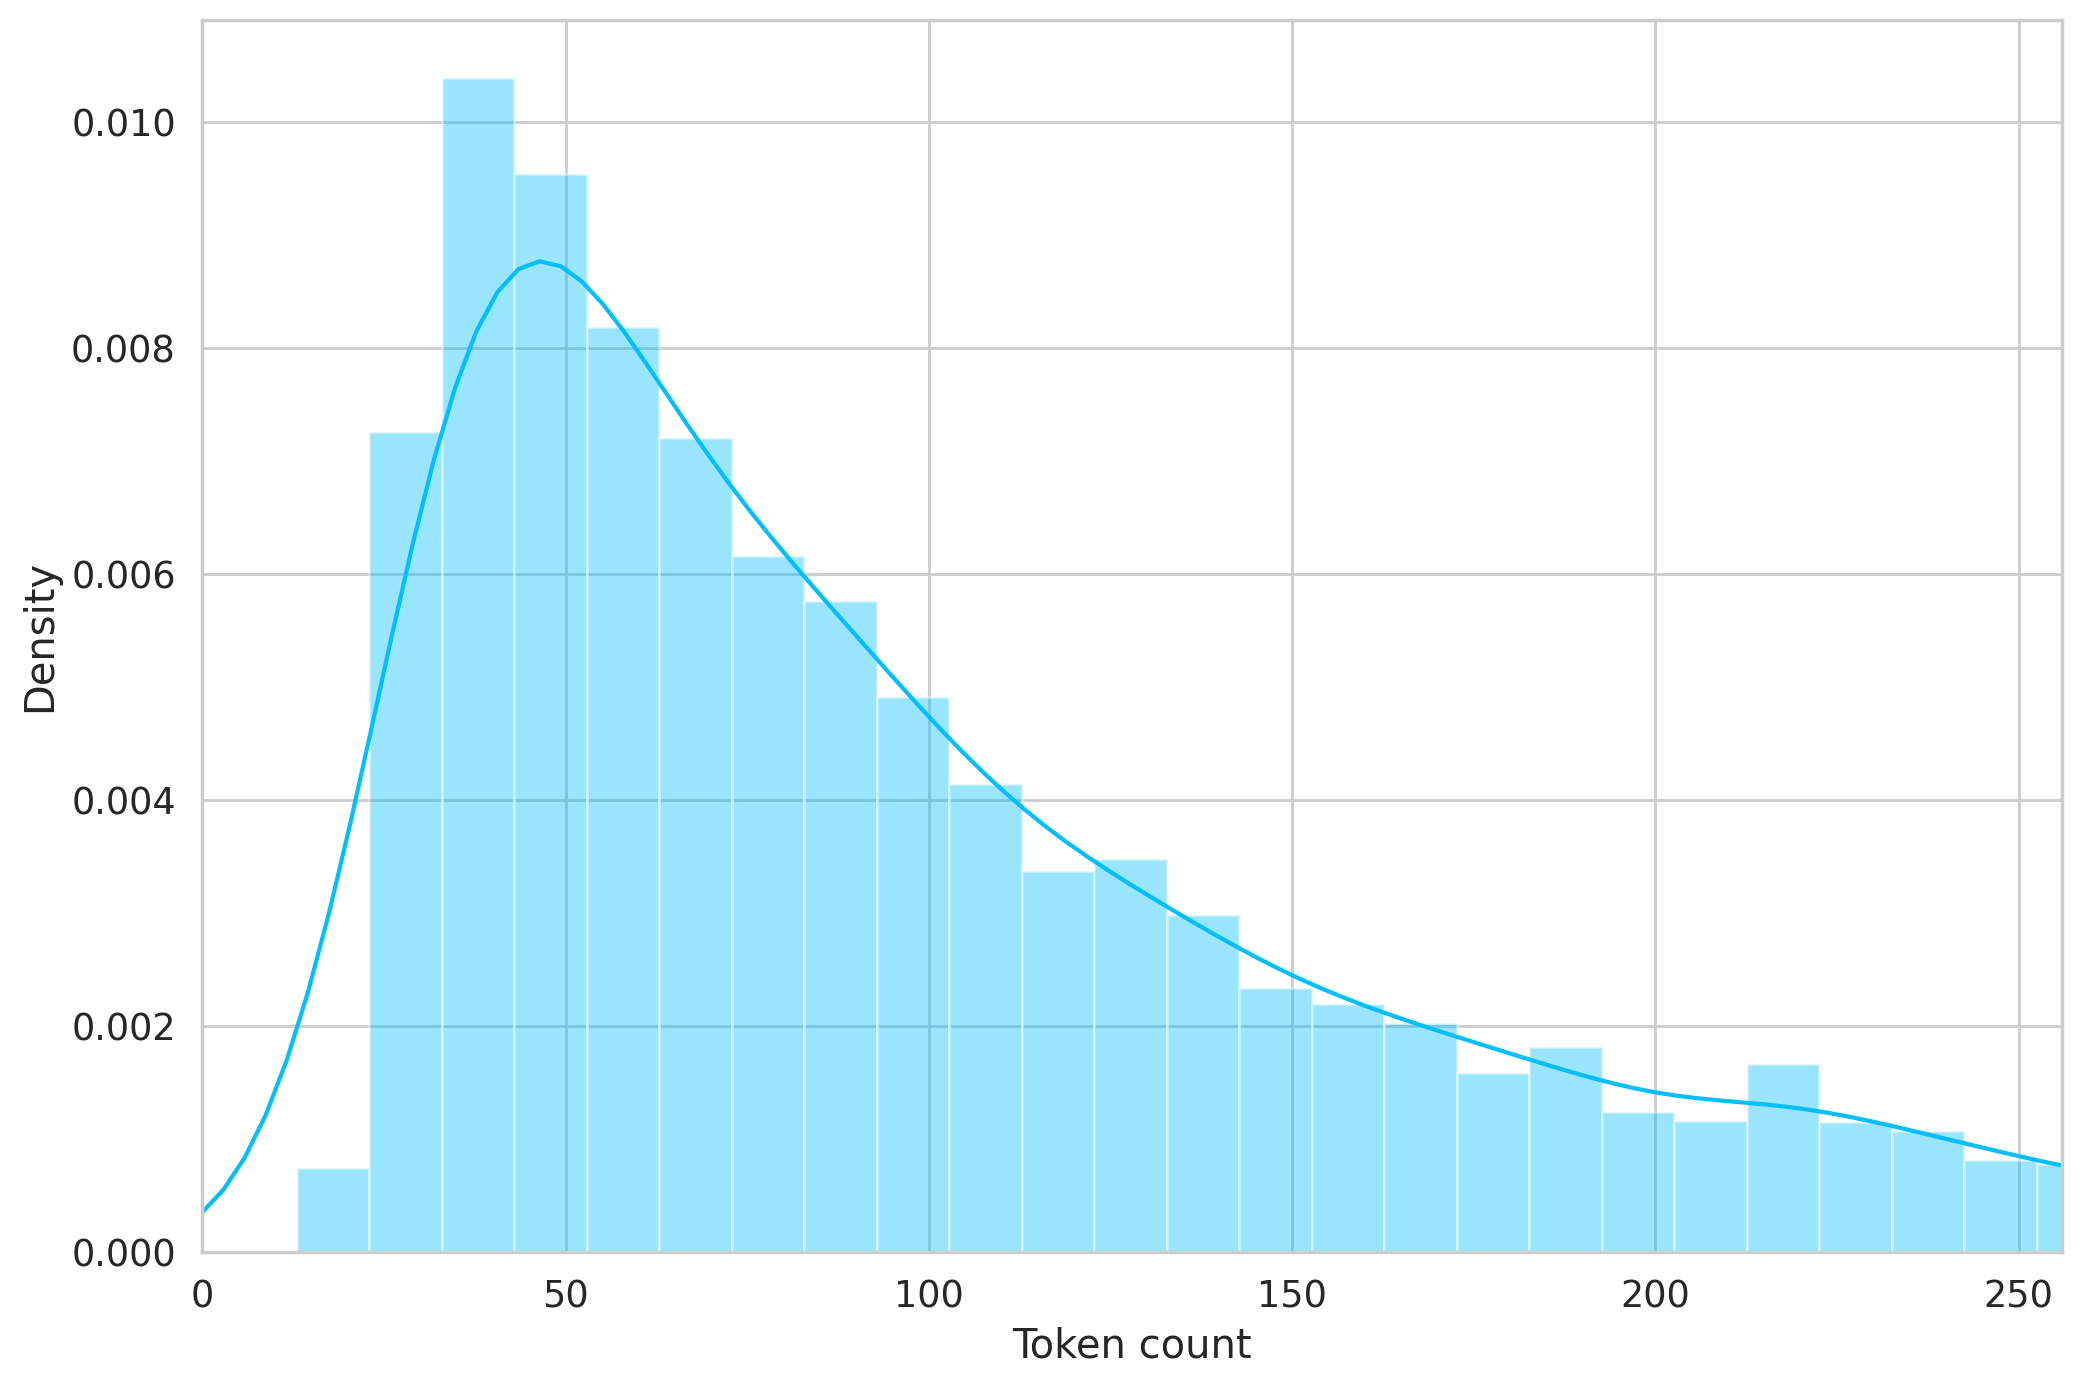

In [20]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
torch.cuda.empty_cache()

The majority of the reviews appear to encompass fewer than 200 tokens; nevertheless, to err on the side of caution, we will opt for a maximum length of 250 tokens.

In [21]:
MAX_LEN = 250
torch.cuda.empty_cache()

Defines a custom dataset class for processing reviews and their corresponding targets using PyTorch. It tokenizes and encodes each review using the specified tokenizer, ensuring a consistent maximum length.


In [22]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

    torch.cuda.empty_cache()

Splitting a DataFrame into three subsets: training, validation, and testing. Initially, it divides the dataset into training and a combined set of validation and test data using train_test_split. Then, it further splits the combined validation and test set into separate validation and test sets, each comprising 5% of the original dataset.

In [23]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
torch.cuda.empty_cache()

In [24]:
df_train.shape, df_val.shape, df_test.shape
torch.cuda.empty_cache()

Code defines a function that prepares a PyTorch DataLoader for a given dataset using a custom dataset class. The function takes as input the DataFrame , a tokenizer, maximum sequence length , and batch size . The custom dataset is created from the reviews and sentiment targets in the DataFrame, and a DataLoader is configured with the specified batch size and the number of workers set to 4 for parallel data loading.



In [25]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
  torch.cuda.empty_cache()

Sets the batch size for training a neural network model using BERT. It then creates data loaders for the training, validation, and test datasets using a specified tokenizer and maximum sequence length.

In [26]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
torch.cuda.empty_cache()

Code is extracting and inspecting a batch of data from the train_data_loader using the iter function and next function.

In [27]:
data = next(iter(train_data_loader))
data.keys()
torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [28]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)
torch.cuda.empty_cache()

torch.Size([16, 250])
torch.Size([16, 250])
torch.Size([16])


Code initializes a BERT model by loading the pre-trained weights specified in the PRE_TRAINED_MODEL_NAME.

In [29]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
torch.cuda.empty_cache()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [30]:
bert_model.config.hidden_size
torch.cuda.empty_cache()

Code defines a PyTorch neural network class called SentimentClassifier, which is a sentiment analysis model based on BERT. It inherits from nn.Module and utilizes a pre-trained BERT model (bert-base-cased). The network includes a dropout layer and a linear layer for classification.

In [31]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = output.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)
        torch.cuda.empty_cache()



In [32]:
model = SentimentClassifier(len(class_names))
model = model.to(device)
torch.cuda.empty_cache()

In [33]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
torch.cuda.empty_cache()

torch.Size([16, 250])
torch.Size([16, 250])


Code uses the softmax function (F.softmax) to apply a softmax activation to the output of a model when given input IDs and attention masks. The dim=1 parameter specifies that the softmax should be applied along the second dimension, which is typically used for class probabilities in classification tasks.

In [34]:
F.softmax(model(input_ids, attention_mask), dim=1)
torch.cuda.empty_cache()

### Training

Code segment utilizes PyTorch's Automatic Mixed Precision (AMP) functionality through torch.

In [35]:
from torch.cuda.amp import autocast, GradScaler
EPOCHS = 10
GRADIENT_ACCUMULATION_STEPS = 1 # Adjust this based on your GPU memory

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS // GRADIENT_ACCUMULATION_STEPS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

scaler = GradScaler()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


This function train_epoch is designed for training a neural network model using PyTorch. It operates for one epoch, iterating over batches from a specified data loader. Within each iteration, it computes model predictions, calculates the loss, performs backpropagation, and updates the model parameters using gradient descent. Additionally, it keeps track of accuracy and average loss for the epoch, returning these values at the end.

In [36]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)
  torch.cuda.empty_cache()

This function evaluates a PyTorch model using a specified data loader, loss function, and device. It operates in evaluation mode, calculating accuracy and average loss over the provided dataset, returning the accuracy and loss values.

In [37]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)
  torch.cuda.empty_cache()

Code use to training the loop.

In [38]:
BATCH_SIZE = 32  # Experiment with larger batch sizes
EPOCHS = 3
GRADIENT_ACCUMULATION_STEPS = 1  # Experiment with different values

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
scaler = torch.cuda.amp.GradScaler()

# Initialize history dictionary
history = defaultdict(list)
# Initialize best_accuracy
best_accuracy = 0
# Rest of your code...

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    model.train()

    for batch_idx, data in enumerate(train_data_loader):
        with autocast():
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, targets)
            scaler.scale(loss).backward()

            if (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

    train_acc, train_loss = eval_model(model, train_data_loader, loss_fn, device, len(df_train))
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

    print(f'Train loss {train_loss} accuracy {train_acc}')
    print(f'Val   loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

    torch.cuda.empty_cache()


Epoch 1/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.1072352560978173 accuracy 0.9678499075134326
Val   loss 0.21082541902985755 accuracy 0.9341792228390167
Epoch 2/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.02894870655088108 accuracy 0.992204703602572
Val   loss 0.16993509220840597 accuracy 0.9452815226011102
Epoch 3/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.014389978423444095 accuracy 0.9964767021932529
Val   loss 0.19404203685949545 accuracy 0.9492466296590008


Code snippet moves the training and validation accuracy tensors to the CPU before plotting a line graph to visualize the training history. It displays the progression of training and validation accuracy over different epochs during the model training process.

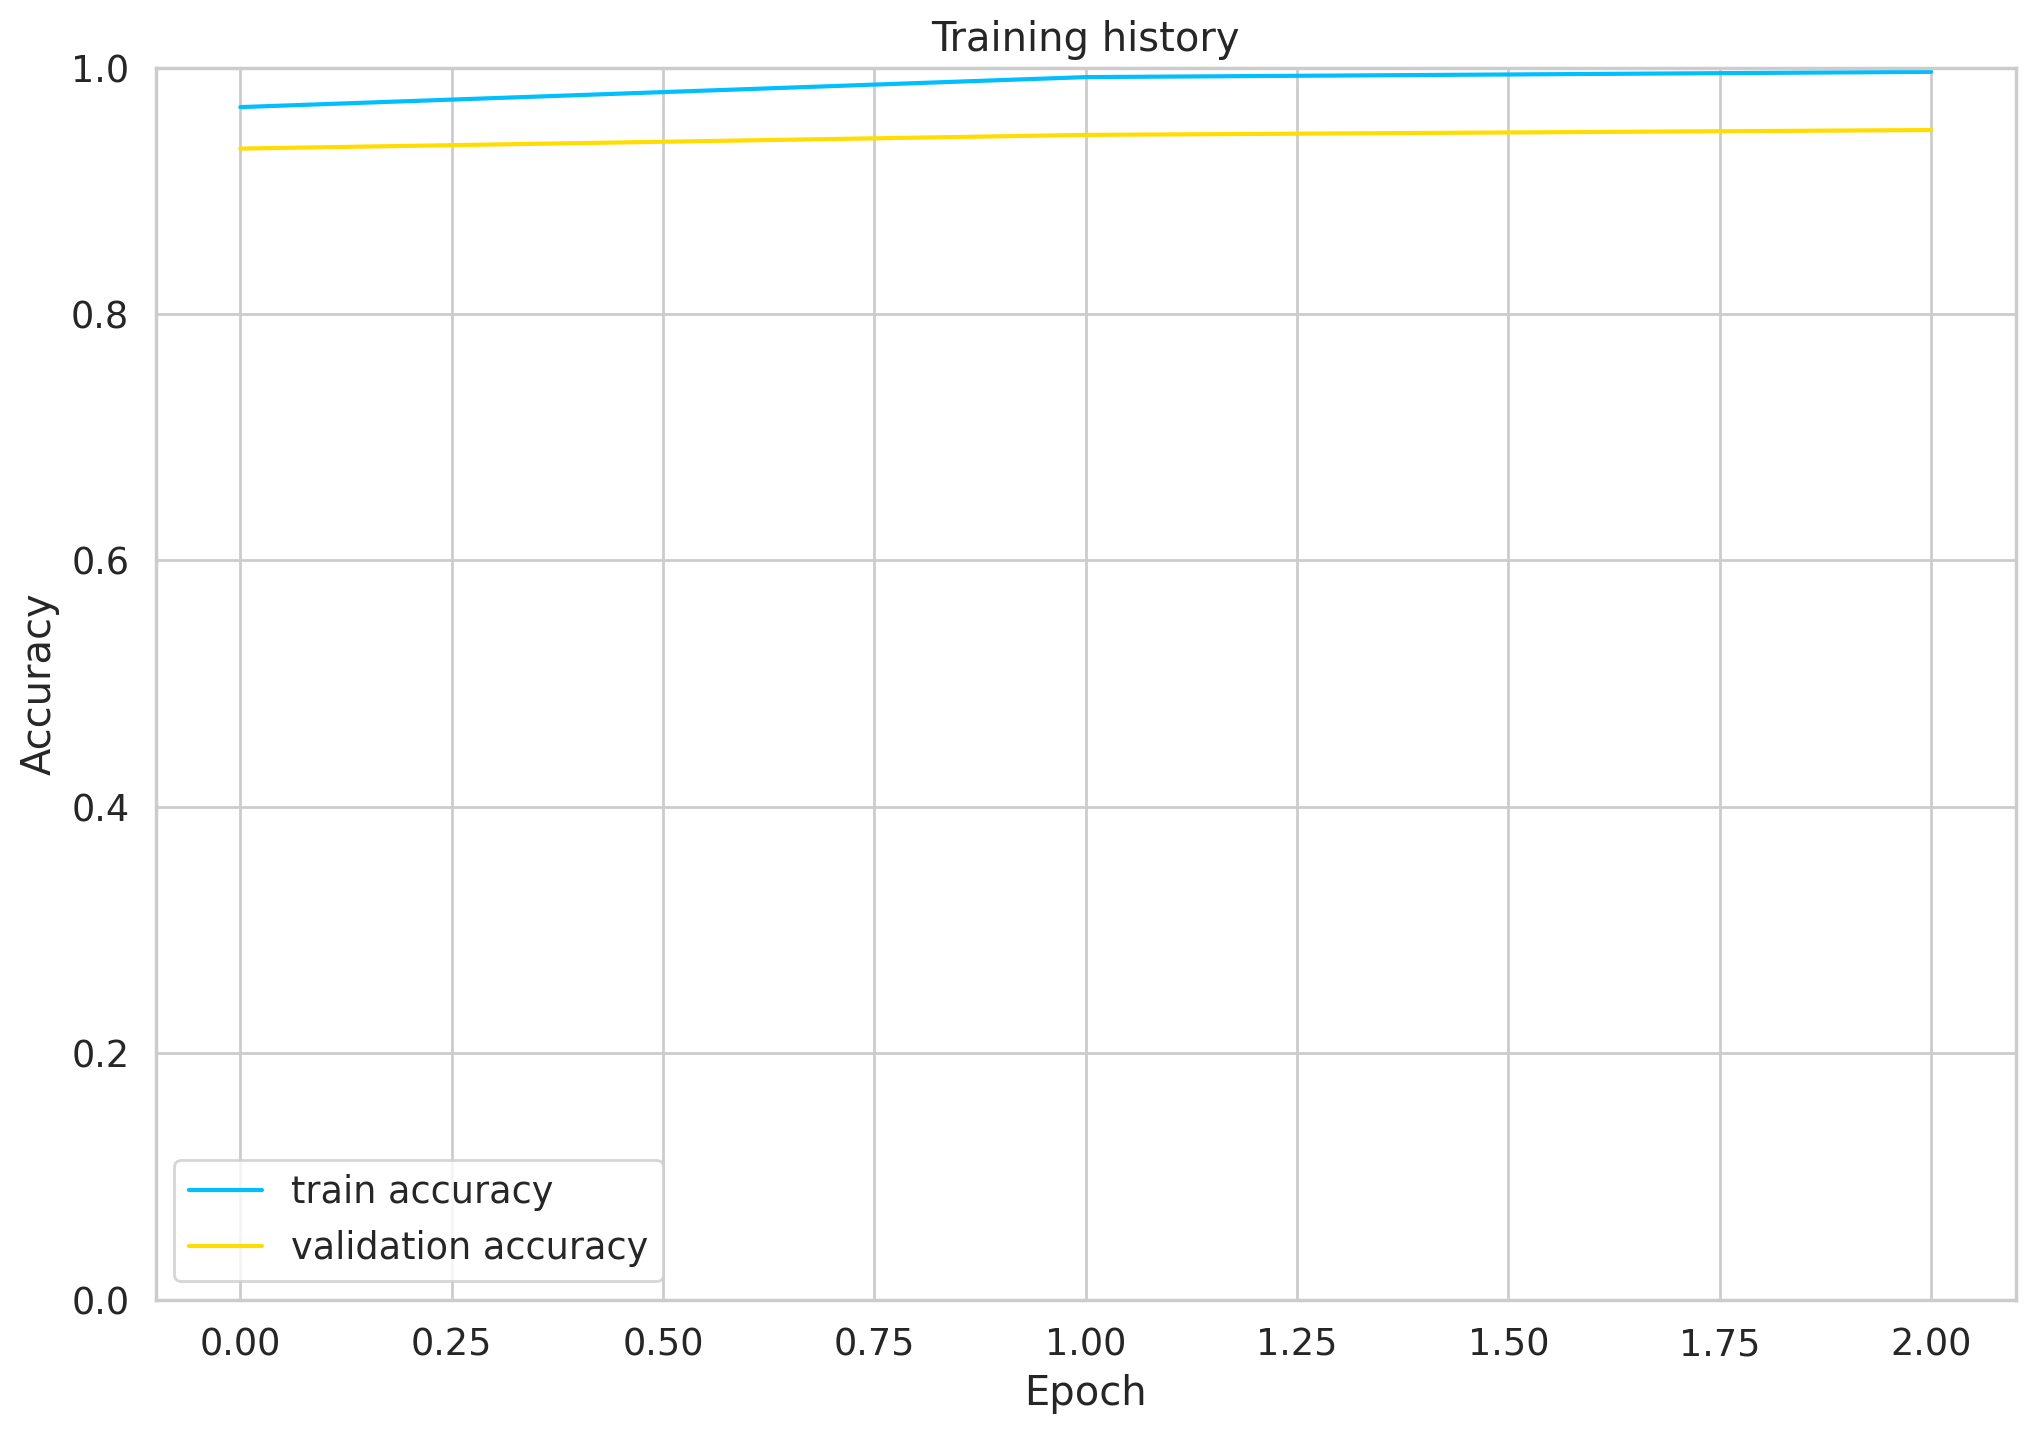

In [40]:
# Move the tensors to CPU before plotting
train_acc_cpu = [acc.cpu().numpy() for acc in history['train_acc']]
val_acc_cpu = [acc.cpu().numpy() for acc in history['val_acc']]

# Plot the training and validation accuracy
plt.plot(train_acc_cpu, label='train accuracy')
plt.plot(val_acc_cpu, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()


## Evaluation

This code evaluates the performance of a machine learning model on a test dataset using a specified loss function.

In [41]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

0.9469096671949288

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [42]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

The function takes a PyTorch model and a data loader as inputs, evaluates the model in evaluation mode, and returns predictions and related information for the given dataset. It iterates through batches in the data loader, computes predictions and probabilities using the model, and accumulates the review texts, predicted labels, prediction probabilities, and true labels. Finally, it returns these lists for further analysis or evaluation.

In [43]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

The classification_report function is used to generate a comprehensive report that includes precision, recall, F1-score, and support for each class in a classification task.

In [44]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.83      0.78      0.80       130
     neutral       0.95      1.00      0.97       570
    positive       0.97      0.93      0.95       562

    accuracy                           0.95      1262
   macro avg       0.92      0.90      0.91      1262
weighted avg       0.95      0.95      0.95      1262



Code defines a function that takes a confusion matrix as input and generates a heatmap using Seaborn to visually represent the true versus predicted sentiments.

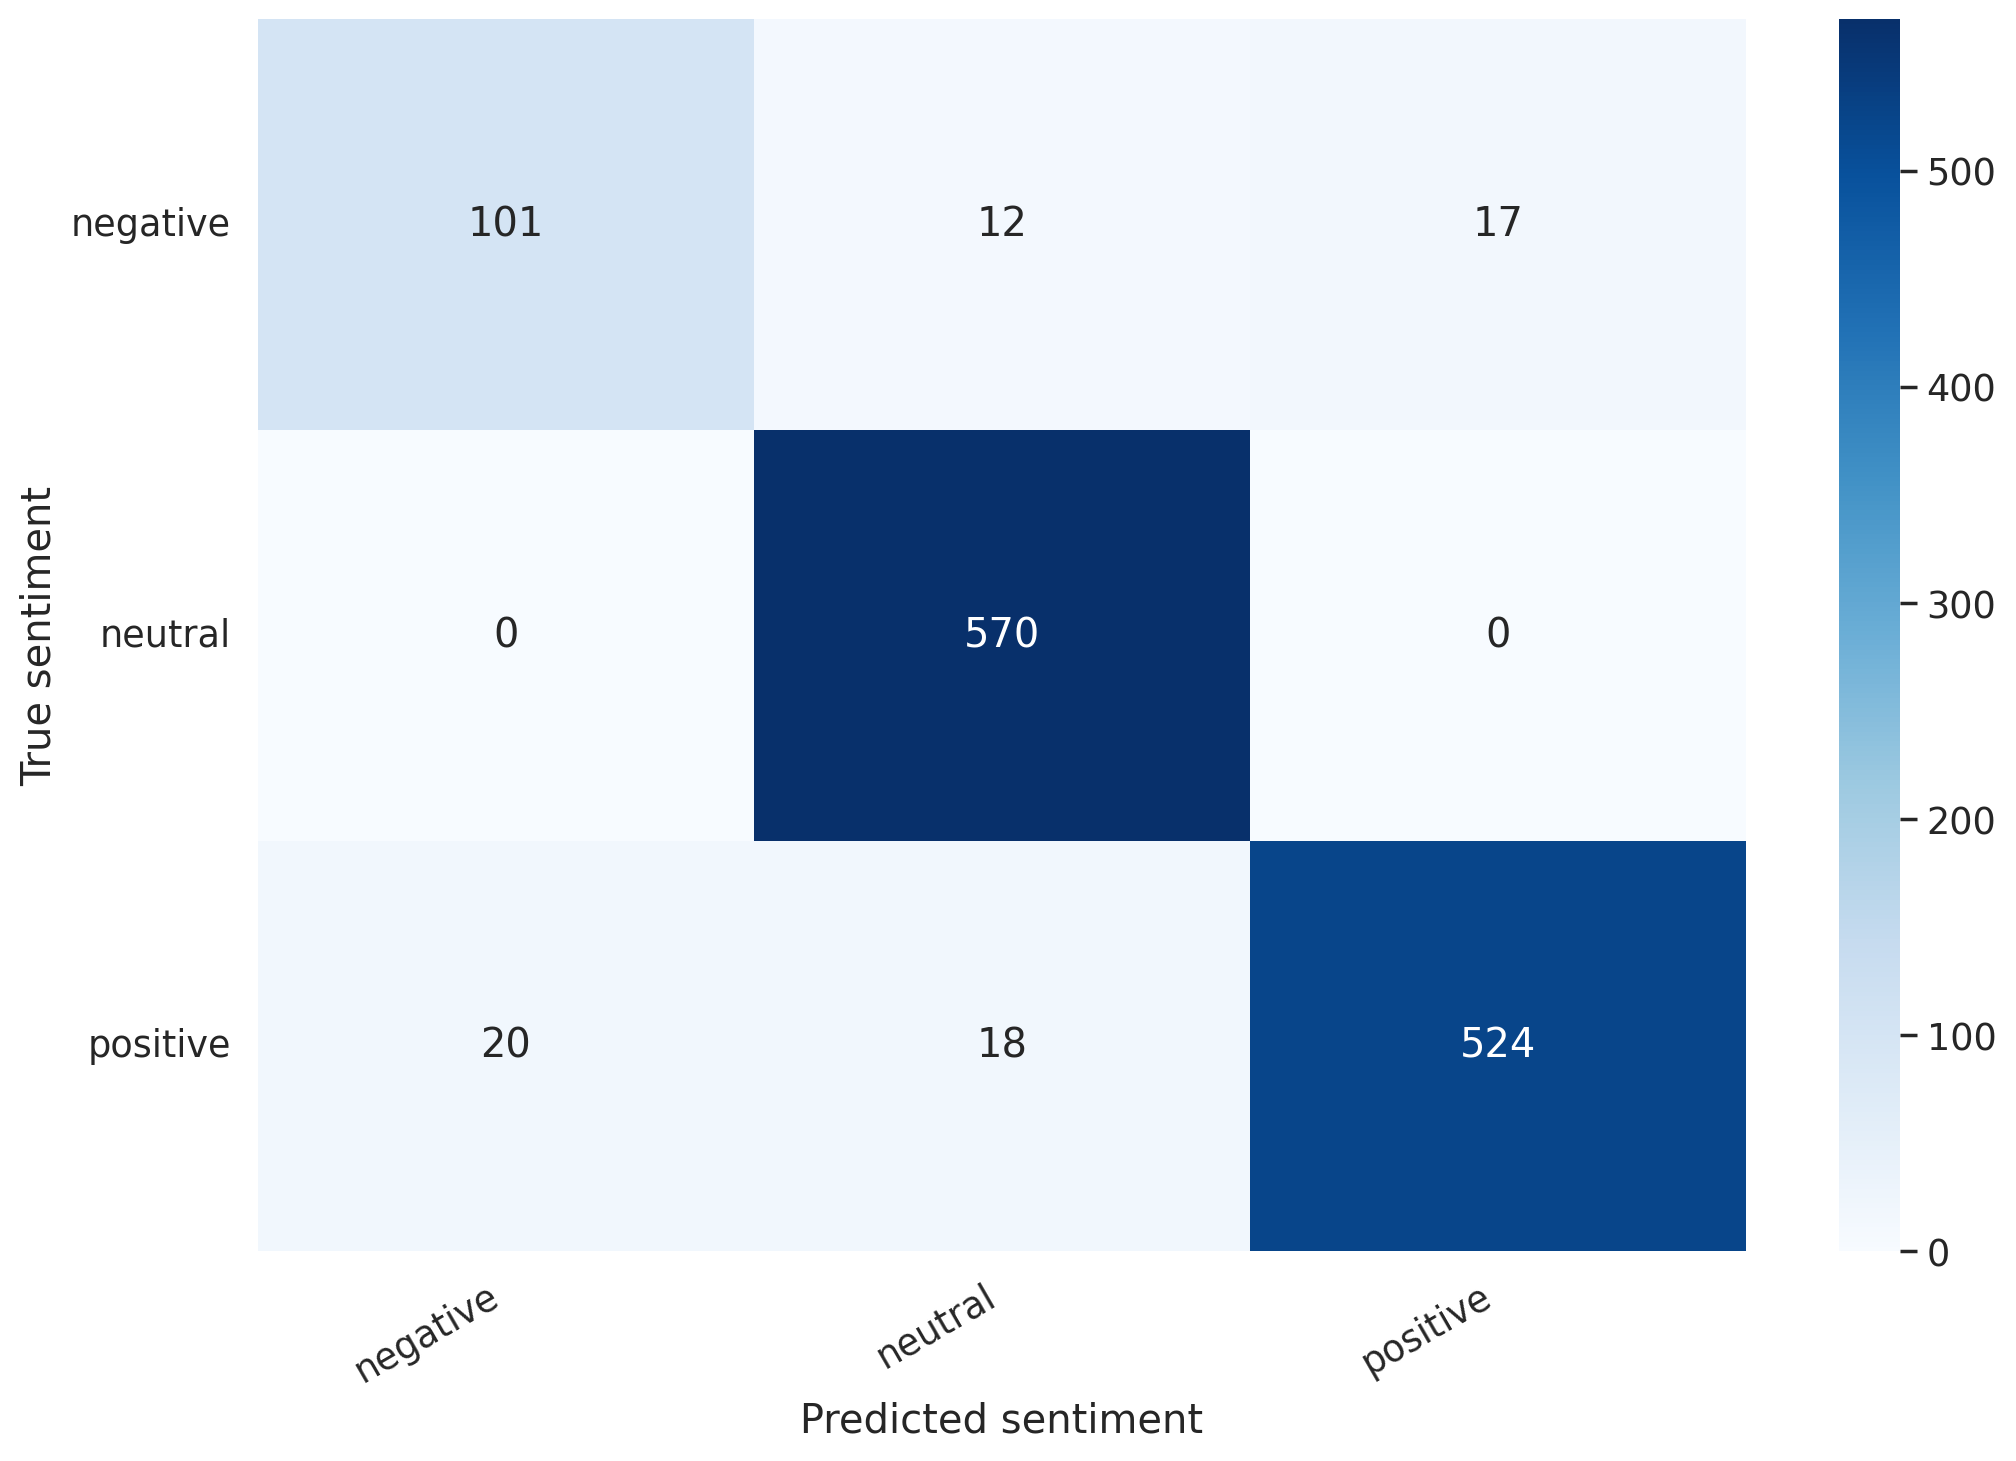

In [45]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Code snippet selects the review text, true sentiment label, and predicted probabilities for each class at index 5 from the test set. It then creates a DataFrame to associate class names with their corresponding predicted probabilities for further analysis or visualization.









In [46]:
idx = 5

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [47]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I have been researching the web to find some gyro strips and this is
the most expensive so far, maybe look elsewhere?

True sentiment: neutral


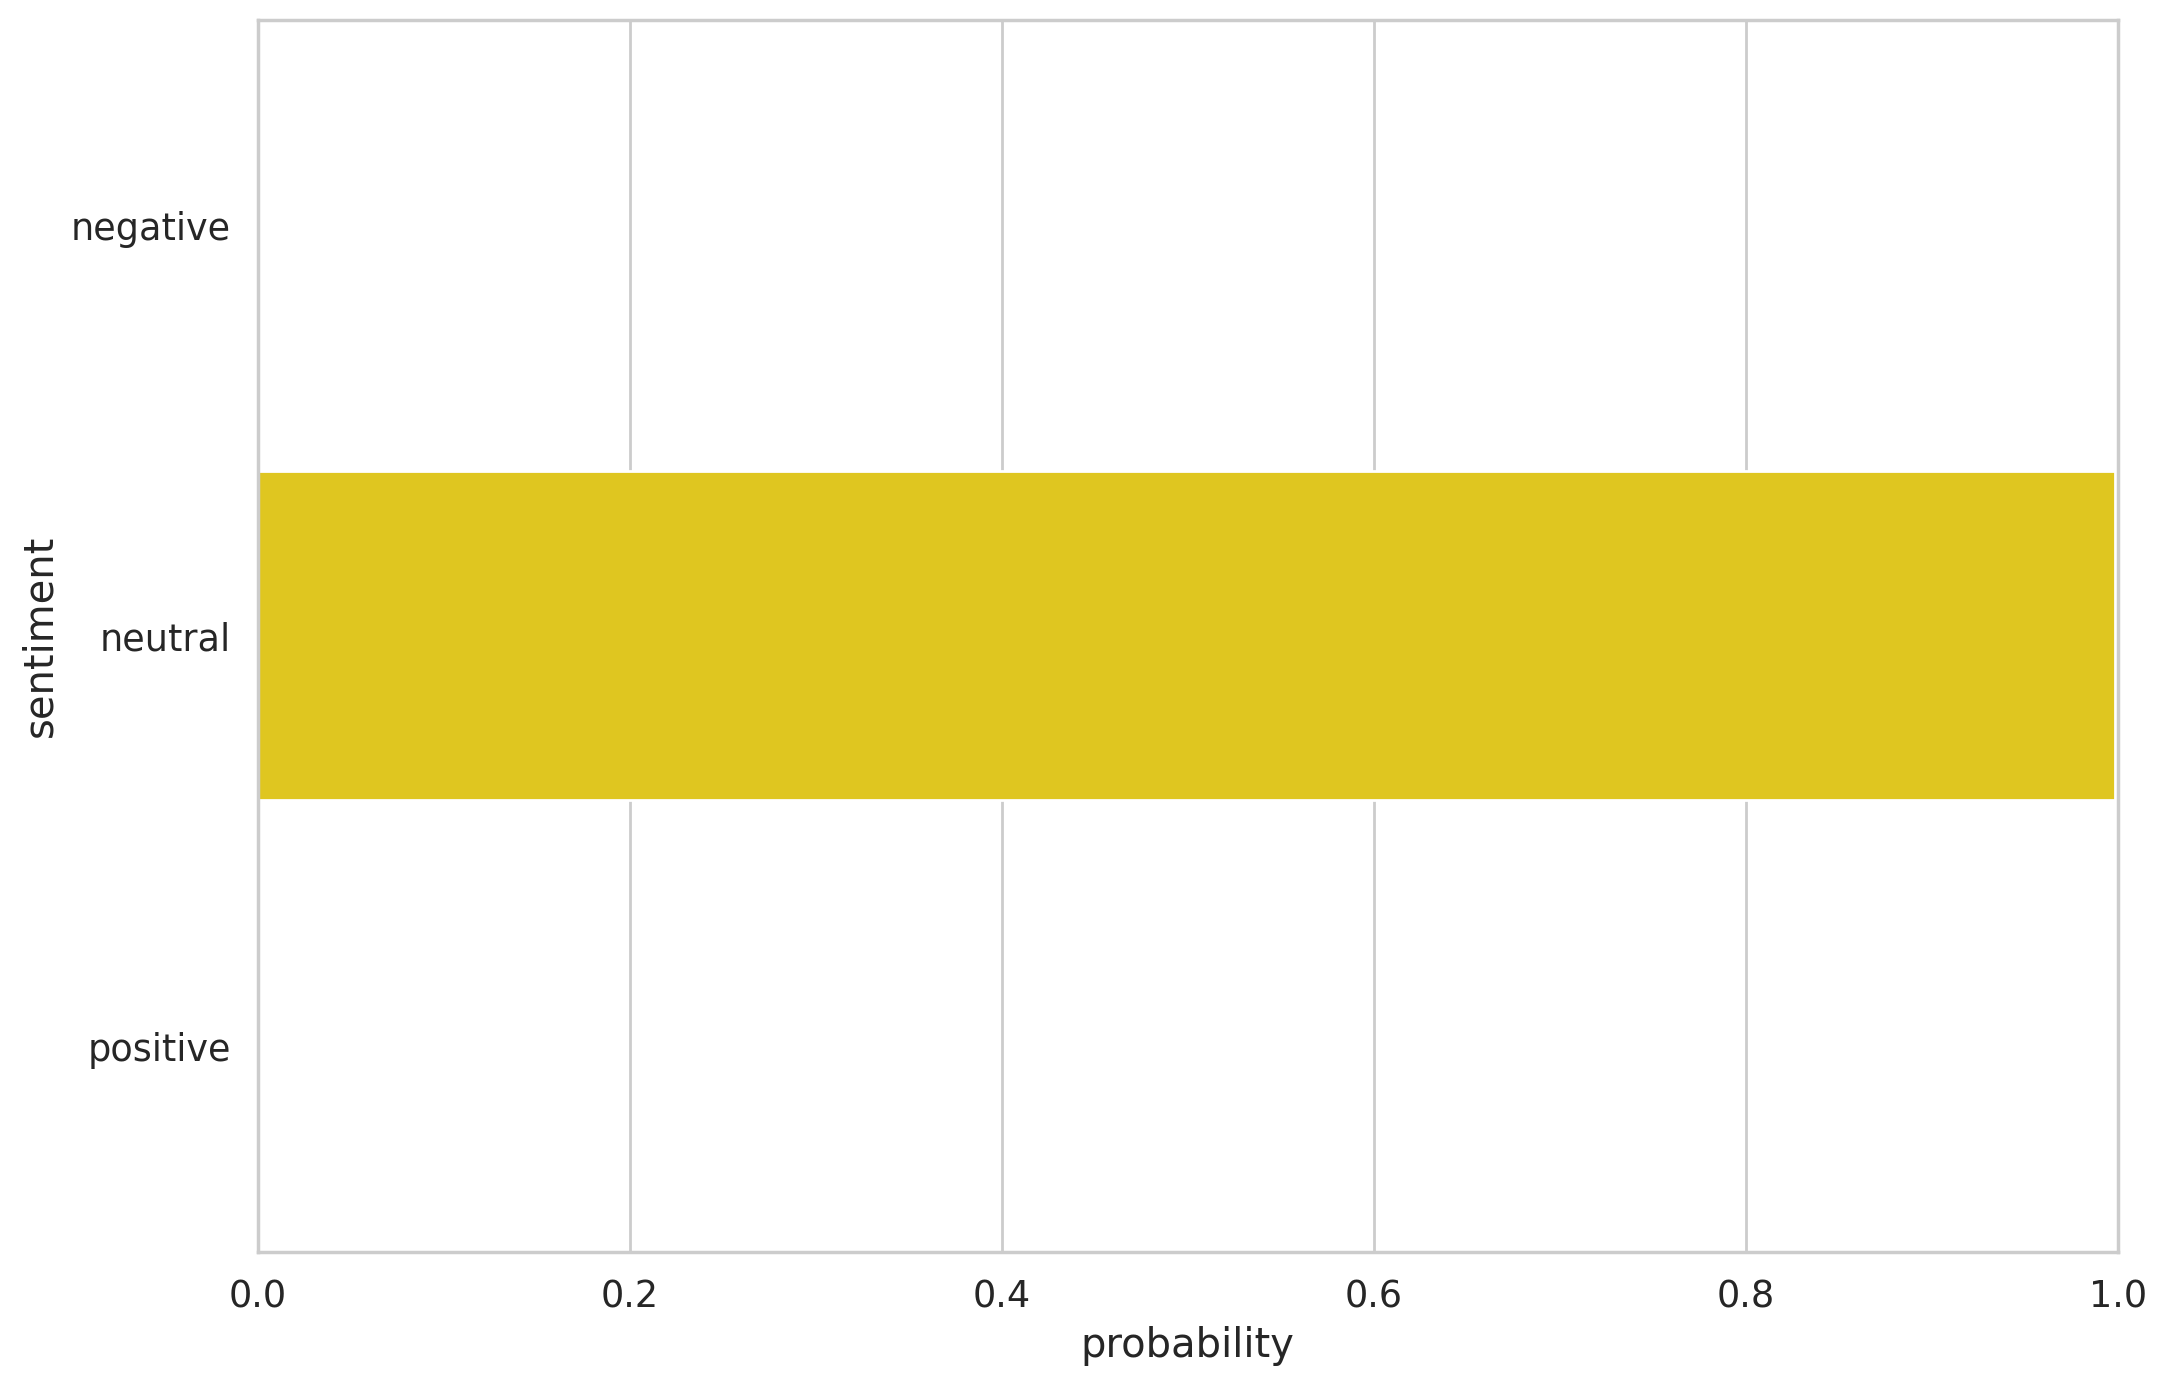

In [48]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Forecast on Raw Text

Developing a model designed to forecast the sentiment of raw textual content.

In [55]:
review_text = "Average financial services. The advice provided was standard, and the performance of my investments was neither outstanding nor disappointing. Communication was adequate, but I expected more personalized insights given the competitive landscape"


This code utilizes the tokenizer to encode a review text by incorporating special tokens, enforcing a maximum length, and ensuring padding to match the specified length.

In [56]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Code segment processes the encoded input_ids and attention_mask of a review on the specified device using a pre-trained sentiment analysis model. The model produces an output, and the predicted sentiment is determined by selecting the class with the highest probability. The final print statements display the original review text and the predicted sentiment class.

In [57]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Average financial services. The advice provided was standard, and the performance of my investments was neither outstanding nor disappointing. Communication was adequate, but I expected more personalized insights given the competitive landscape
Sentiment  : positive
